# EE4375-2022: Sixth Lab Session: Galerkin Finite Element Method for the Poisson Equation on the Unit Square 

 Solves the Poisson equation $- \bigtriangleup u = f$ on the unit square domain $\Omega=(0.,1.0)^2$ supplied with the homogeneous Dirichlet boundary condition $u = 0$ on $\Gamma$. The computational domain is kept simple on purpose for illustration purposes. The source function $f$ is defined as the sourcefct in what follows. Linear finite elements on triangular elements are used. The mesh is generated using the mesh generation software called gmsh (see [Gmsh](https://gmsh.info)). More information on the use of GMSH is provided at [extended-lab-sessions/gmsh](https://github.com/ziolai/finite_element_electrical_engineering/tree/main/extended-lab-sessions/gmsh).

## Import Packages

In [1]:
import Gmsh: gmsh 
using GR 
using LinearAlgebra
using SparseArrays 
using Plots
using LaTeXStrings

## Section 1: Geometry and Mesh Generation of Unit Square Geometry 
The code that follows performs <b>geometry generation</b> and <b>mesh generation</b> on the unit square geometry. 

First the <b>geometry</b> is generated in the following five steps:
1. four corner points of the square are defined. The points are labeled as 1 through 4;
2. four lines are defined as the edges of the square are defined by connecting previously defined points. Edges are formed by connecting points pairwise. The lines are given a start and end point. The lines are thus oriented. The edges are labeled as 1 through 4;  
3. the boundary of the square is defined by a loop connecting the four edges. The orientation of the edges given an orientation to the loop. The loop is oriented such that an imaginary observer walking on the loop finds the domain on his left-hand side. The loop is labeled as 1;  
4. the surface of the square is defined by the loop. It is on this square that the mesh generation will take place. This square is labeled as 1; 
5. a name is given to the surface; 

Next the <b>mesh</b> on the geometry is defined by mesh generation. The mesh is generated by first meshing the four edges of the square. The mesh is subsequently propagated towards the interior of the square. The mesh density is controlled by the parameter lc. 

The mesh is optionally written to file and visualized using the GUI. 

<b>Exercises </b>: 
1. change coordinate of one of the points and regenerate the mesh;
2. change the mesh density by changing the value of the parameter lc and regenerate the mesh. Apply different mesh density on one or more point or edges of the square; 
3. extend the code to the generation of a mesh on a pentagon; 
4. extend the code to the generation of a mesh on an L-shaped domain; 
5. extend the code to the generation of a mesh on a square with an inner square removed this practising the orientation of the loops; 
6. share imagines of the meshes obtained of social media of choice and notify your favorite finite element instructor; 

In [2]:
#..1/4: initialize gmsh 
gmsh.initialize()

#..2/4: generate geometry 
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("square")
#..set mesh density parameter 
lc = .02
#..define four points via (x,y,z) coordinates 
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
#..define four edges by connecting point labels pairwise  
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
#..define curved loop by connecting four edge labels  
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
#..define surface by curved loop 
gmsh.model.geo.addPlaneSurface([1], 1)
#..give label to the surface 
#..syntax of the function being used is gmsh.model.setPhysicalName(dim, tag, name) 
gmsh.model.setPhysicalName(2, 1, "My surface")
#..synchronize model 
gmsh.model.geo.synchronize()

#..3/4: generate two-dimensional mesh 
gmsh.model.mesh.generate(2)
#..if true, write mesh to file for further processing 
if (true) gmsh.write("square.msh") end 
#..if true, visualize mesh through the GUI 
if (false) gmsh.fltk.run() end 

#..4/4: finalize gmsh 
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000271625s, CPU 0.000191s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0498825s, CPU 0.049538s)
Info    : 3014 nodes 6030 elements
Info    : Writing 'square.msh'...
Info    : Done writing 'square.msh'


## Section 2:/ Read Mesh from file and perform loop over the elements 
Exercise: 
- verify that sum of area of elements over mesh equals area of entire 2D domain;

In [3]:
#..1/4: Finalize gmsh
gmsh.initialize()

#..2/4: Read mesh from file
gmsh.open("square.msh")

#..3/4: perform loop over the elemements 
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])
  
for element_id in 1:nelements

    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]

    if (false)
      println("on element ", element_id, " node-1 has global number ", node1_id)
      println("on element ", element_id, " node-2 has global number ", node2_id)
      println("on element ", element_id, " node-3 has global number ", node3_id)
      println(" ")
    end 

end 

#..4/4: Finalize gmsh
gmsh.finalize()

Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 3014 nodes
Info    : 6030 elements
Info    : Done reading 'square.msh'


## Section 3:/ Extract Data from the Mesh and Perform a FEM Computation  
This version of the code performs a single loop over the elements. The loop over the degrees of freedom inside the loop over the elements is avoided. 

Exercises: 
1. study the assembly of the vector;
2. study the assembly of the matrix; 

In [4]:
function area_triangle(x1,x2,x3,y1,y2,y3)
    x12 = x2 - x1; x13 = x3-x1;
    y12 = y2 - y1; y13 = y3-y1;
    area_id = x12*y13 - x13*y12; 
    area_id = abs(area_id)/2
    return area_id 
end

area_triangle (generic function with 1 method)

In [5]:
#..1/12: Finalize gmsh
gmsh.initialize()

#..2/12: Generate the mesh
gmsh.open("square.msh")

#..3/12 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Define the source function and apply the source function to the local coordinates
sourcefunction(x,y) = 4*(x-x^2)+4*(y-y^2)
sourcefunction(x,y) = x+y
fvalues = map(sourcefunction, xnode, ynode)

#..6/12 Initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
M = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..7/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  I = Vector{Int64}([node1_id; node2_id; node3_id])

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  area_id = area_triangle(xnode1,xnode2,xnode3,ynode1,ynode2,ynode3)

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end
    
  #....compute local vector contribution floc of the current element
  floc = area_id/3*fvalues[I]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*(transpose(Emat)*Emat);
  Mloc = area_id/3*[1 0 0; 0 1 0; 0 0 1]; 
    
  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  f[I] += floc
  A[I,I] += Aloc
  M[I,I] += Mloc

end

#..8/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..9/12 Make A sparse and M diagonal 
A = sparse(A)
M = Diagonal(M)

#..10/12 Compute the numerical solution
u = A\f

#..10/12: Finalize gmsh
gmsh.finalize()

#..11/12 Plot the numerical solution
GR.trisurf(xnode,ynode,u)

Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 3014 nodes
Info    : 6030 elements
Info    : Done reading 'square.msh'


## Section 4:/ Magnetic Field by Coil  

Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 3014 nodes
Info    : 6030 elements
Info    : Done reading 'square.msh'


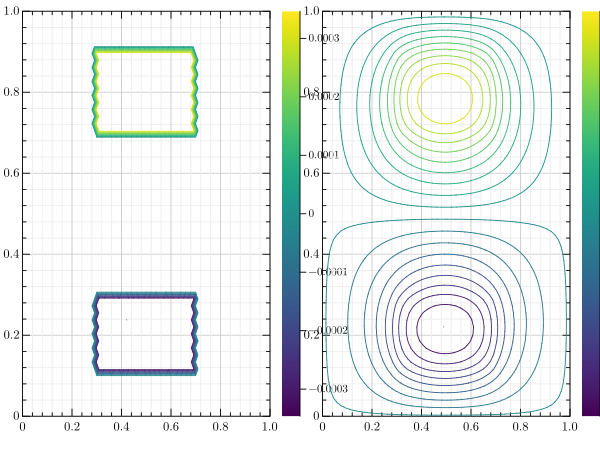

In [6]:
#..1/12: Finalize gmsh
gmsh.initialize()

#..2/12: Generate the mesh
gmsh.open("square.msh")

#..3/12 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Define the source function and apply the source function to the local coordinates
#sourcefunction(x,y) = x+y
sourcefunction(x,y) = (x>0.3)*(x<0.7)*(y>0.7)*(y<0.9) - (x>0.3)*(x<0.7)*(y>0.1)*(y<0.3) 
fvalues = map(sourcefunction, xnode, ynode)

#..6/12 Initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
M = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..7/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  I = Vector{Int64}([node1_id; node2_id; node3_id])

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  area_id = area_triangle(xnode1,xnode2,xnode3,ynode1,ynode2,ynode3)

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end

  #....compute local vector contribution floc of the current element
  floc = area_id/3*fvalues[I]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*(transpose(Emat)*Emat);
  Mloc = area_id/3*[1 0 0; 0 1 0; 0 0 1]; 
    
  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  f[I] += floc  
  A[I,I] += Aloc
  M[I,I] += Mloc

end

#..8/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..9/12 Make A sparse and M diagonal 
A = sparse(A)
M = Diagonal(M)

#..9/12 Compute the numerical solution
u = A\f

#..10/12: Finalize gmsh
gmsh.finalize()

#..11/11 Plot the source term and the numerical solution
GR.subplot(1,2,1)
p1 = GR.tricont(xnode,ynode,f)
GR.subplot(1,2,2)
p1 = GR.tricont(xnode,ynode,u)

## Section 5:/ Post-Processing for the Flux

In [7]:
xmid = zeros(nelements,1)
ymid = zeros(nelements,1)
Bx = zeros(nelements,1)
By = zeros(nelements,1)
normB2 = zeros(nelements,1)

for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  I = Vector{Int64}([node1_id; node2_id; node3_id])

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  area_id = area_triangle(xnode1,xnode2,xnode3,ynode1,ynode2,ynode3)

  #....compute local vector contribution floc of the current element
  floc = area_id/3*fvalues[I]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  uloc = u[I]
  
  xmid[element_id] = (xnode1+xnode2+xnode3)/3
  ymid[element_id] = (ynode1+ynode2+ynode3)/3
  Bx[element_id] = uloc[1]*Emat[2,1]+uloc[2]*Emat[2,2]+uloc[3]*Emat[2,3]
  By[element_id] = uloc[1]*Emat[1,1]+uloc[2]*Emat[1,2]+uloc[3]*Emat[1,3]
  normB2[element_id] = Bx[element_id]^2 + By[element_id]^2 

end

GR.subplot(1,2,1)
p1 = GR.tricont(xmid,ymid,Bx)
GR.subplot(1,2,2)
p1 = GR.tricont(xmid,ymid,normB2)

## Section 6:/ Solving the Scalar Diffusion Equation in Time Domain 

In [8]:
using DifferentialEquations

### Defining the Problem 

In [9]:
#..define the right-hand side of the ordinary differential equation of the equation of motion 
function scalarDiffusionEquation!(du,u,p,t)
    du .= M \ (sin(2*π*50*t)*f - A*u)
end

#..set initial position and velocity
u0 = fill(1.,nnodes)
                                    
#..set time begin and end forward
t0 = 0.0
tf = 2.0
tspan = (t0,tf)

#..define ODE problem to be solved  
prob_scalarDiffusion = ODEProblem(scalarDiffusionEquation!, u0, tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob_scalarDiffusion);

### Plotting the computed solution 
Requires code optimization (unclear why and how). 

In [ ]:
dt = 2
tvec = Vector(t0:dt:tf)

Plots.plot(sol)
for i in 2:nnodes-1
    Plots.plot!(sol,vars=i)
end
p1 = Plots.plot!(sol)
title!("Displacement")

#..plot solution of velocity and position as function of time  
Plots.plot(p1)

In [ ]:
anim = @animate for i in t0:tf
    Plots.surface(xnode,ynode,sol(i/10),st=:surface)
    zlims!(-.2, 1.5)
end
gif(anim, "my-animation.gif", fps = 1)

## Section 7:/ Solving a Modified Scalar Diffusion Equation in Time Domain 

In [ ]:
# set damping matrix
C = .005*M 

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function scalarWaveEquation!(ddu,du,u,p,t)
    ddu .= M \ (f - A*u - C*du)
end

#..set initial position and velocity
u0 = fill(0.,nnodes)

v0 = zeros(nnodes)
# v0[4] = 1
                                    
#..set time begin and end forward
t0 = 0.0
tf = 20.0
tspan = (t0,tf)           

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(scalarWaveEquation!,v0,u0,tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob);

### Post-plotting the Solution using time-traces  

In [ ]:
dt = 1
tvec = Vector(t0:dt:tf)

#..velocity and position have vars=(1:N) and vars=(N+1,2N), respectively. 
Plots.plot(sol,vars=1)
for i in 2:nnodes-1
    Plots.plot!(sol,vars=i)
end
p1 = Plots.plot!(sol,vars=nnodes)
title!("Velocity")

plot(sol,vars=nnodes+1)
for i in nnodes+2:2*nnodes-1
    Plots.plot!(sol,vars=i)
end
p2 = Plots.plot!(sol,vars=2*nnodes)
title!("Displacement")

#..plot solution of velocity and position as function of time  
Plots.plot(p1,p2,layout=(2,1))

### Post-plotting using animation 

In [ ]:
anim = @animate for i in t0:tf
    Plots.surface(xnode,ynode,sol(i/10)[nnodes+1:2*nnodes],st=:surface)
    zlims!(-.2, .4)
end
gif(anim, "my-animation.gif", fps = 15)

## Section 8:/ Further Improvements/Extensions to this Notebook 
1. avoid matrix $A$ to be dense. Instead, declare $A$ to be sparse (without pre-allocating memory for $A$). Traverse over elements, assemble I, J, Avals lists. After traversal, use sparse to construct the $A$ matrix (see 1D FEM code). Implement traversal using both for loop and map; 
2. put assembly inside function. Test function for type stability. Profile assemby of matrix and vector for various problem sizes. Check whether making Aloc to be a static matrix has any advantages. Check whether updating lists for I, J and Avals in place has any advanges;  
3. idem for solve. Replace backslash by iterative solution method (AMG as preconditioner for CG) and profile again;  
4. create seperate function to generate Aloc, Mloc and floc allowing to introduce quadrature on the element; 
5. create assembly on quadrilateral elements; 
6. create assembly for second order triangular (quadrilateral) elements; 
7. create assembly for non-homogeneous Neumann boundary conditions; 
8. create assembly for three-dimensional geometries; 